In [1]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras import  layers, models



from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, MaxPool2D, Activation
from sklearn.utils import shuffle
from sklearn import metrics
#from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [3]:
from PIL import Image
import glob
import os

# Now you can use functions from the glob module

# Rest of your code

from tensorflow.keras.utils import to_categorical

lung_cancer_dataset_path = r"/content/drive/MyDrive/Sem4_Project /Lung Cancer/Dataset"
imagePatches = glob.glob(os.path.join(lung_cancer_dataset_path, '**', '*.*'), recursive=True)

x = []
y = []

for img_path in imagePatches:

    # Check if the file is an image (jpg, png, etc.)
    _, file_extension = os.path.splitext(img_path)
    if file_extension.lower() in {'.png', '.jpg', '.jpeg'}:
        # Use PIL to open the image
        try:
            img = Image.open(img_path)
            img = img.resize((224, 224))

            # Convert RGBA or other modes to RGB
            if img.mode != 'RGB':
                img = img.convert('RGB')

            im = np.array(img) / 255.0  # Normalize pixel values
            x.append(im)

            # Extract the class label from the subdirectory name
            class_label = os.path.basename(os.path.dirname(img_path))

            if 'benign' in class_label:
                y.append(0)
            elif 'malignant' in class_label:
                y.append(1)
            elif 'normal' in class_label:
                y.append(2)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

x = np.array(x)
y = np.array(y)


In [4]:
print("Number of images:", len(imagePatches))

Number of images: 2074


In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=101, stratify=y)

# One-hot encode the labels for training and validation sets
y_train = to_categorical(y_train, num_classes=3)
y_valid = to_categorical(y_valid, num_classes=3)

# Delete the original x and y to free up memory
del x, y


In [6]:
# config the session
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(111)
from random import seed
seed(111)

In [7]:
from keras import layers, Model, backend

channel_axis = -1  # color channels are expected to be the last dimension of the input data

def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), name=None):
    """Convolution Block with BatchNormalization and ReLU activation."""
    if name is not None:
        conv_name = name + '_conv'
        bn_name = name + '_bn'
        act_name = name + '_act'
    else:
        conv_name = None
        bn_name = None
        act_name = None

    x = layers.Conv2D(filters, kernel_size,
                      strides=strides,
                      padding='same',
                      use_bias=False,
                      name=conv_name)(input_tensor)
    x = layers.BatchNormalization(axis=channel_axis, name=bn_name)(x)
    x = layers.Activation('relu', name=act_name)(x)

    return x

def residual_block(input_tensor, filters, kernel_size, strides=(1, 1), adjust_dimensions=False, block_name=None):
    """A Residual Block with optional dimension adjustment."""
    # Path to adjust dimensions if needed
    shortcut = input_tensor
    if adjust_dimensions:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization(axis=channel_axis)(shortcut)

    # Main path
    x = conv_block(input_tensor, filters, kernel_size, strides=strides, name=f'{block_name}_conv1')
    x = conv_block(x, filters, kernel_size, strides=(1, 1), name=f'{block_name}_conv2')

    # Adding back the shortcut path
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_model():
    img_input = layers.Input(shape=(224, 224, 3))

    # Initial Conv Block
    x = conv_block(img_input, 32, (3, 3), name='block1')
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool')(x)

    # First Residual Block
    x = residual_block(x, 32, (3, 3), block_name='block2')

    # Further blocks can be added in a similar fashion
    # Notice we need to adjust dimensions when increasing the number of filters
    x = residual_block(x, 64, (3, 3), adjust_dimensions=True, strides=(2, 2), block_name='block3')

    # Continue building your model
    # For simplicity, adding one more block and then going to dense layers
    x = residual_block(x, 128, (3, 3), adjust_dimensions=True, strides=(2, 2), block_name='block4')
    x = layers.MaxPooling2D((3, 3), strides=(3, 3), padding='same', name='final_pool')(x)

    # Final Dense Layers
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.Dense(3, activation='softmax', name='predictions')(x)

    model = Model(inputs=img_input, outputs=x, name='model_with_skip_connections')
    return model

model = build_model()
model.summary()


Model: "model_with_skip_connections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv (Conv2D)        (None, 224, 224, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_bn (BatchNormalizat  (None, 224, 224, 32)         128       ['block1_conv[0][0]']         
 ion)                                                                                             
                                                                                                  
 block1_act (Activation)     (None, 224, 224, 32)         0         ['bl

In [8]:
LEARN_RATE = 1e-4
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(lr = LEARN_RATE), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}.best_only.hdf5".format('save')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, verbose=1, mode='auto',
                              epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=40) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early,reduceLROnPlat]

In [10]:

history = model.fit(x_train,y_train,batch_size = 16,
                    epochs = 100, verbose=1,  validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
83/83 [==============================] - ETA: 0s - loss: 6.3718 - categorical_accuracy: 0.6910
Epoch 1: val_loss improved from inf to 13.19693, saving model to save.best_only.hdf5
83/83 [==============================] - 17s 91ms/step - loss: 6.3718 - categorical_accuracy: 0.6910 - val_loss: 13.1969 - val_categorical_accuracy: 0.6777 - lr: 0.0010
Epoch 2/100
82/83 [============================>.] - ETA: 0s - loss: 0.7767 - categorical_accuracy: 0.7774
Epoch 2: val_loss did not improve from 13.19693
83/83 [==============================] - 4s 49ms/step - loss: 0.7716 - categorical_accuracy: 0.7784 - val_loss: 34.5542 - val_categorical_accuracy: 0.6777 - lr: 0.0010
Epoch 3/100
82/83 [============================>.] - ETA: 0s - loss: 0.3901 - categorical_accuracy: 0.8834
Epoch 3: val_loss did not improve from 13.19693
83/83 [==============================] - 4s 49ms/step - loss: 0.3981 - categorical_accuracy: 0.8824 - val_loss: 16.6921 - val_categorical_accuracy: 0.6777 - lr: 

In [11]:
# Save the entire model (architecture and weights)
model.save(r"/content/drive/MyDrive/Sem4_Project /Pneumonia/lungcancer_resnet.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
#evaluates the trained model on a validation set and prints the test loss and accuracy.
test_loss, test_score = model.evaluate(x_valid, y_valid, batch_size=24)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)
#2304 seconds 50 epochs
#192 ms/step = average ms/step

18/18 [==============================] - 2s 42ms/step - loss: 0.2216 - categorical_accuracy: 0.9807
Loss on test set:  0.22161978483200073
Accuracy on test set:  0.9807229042053223


In [13]:
#predictions using the trained model on the validation set (x_valid).
#pred_y will contain the predicted outputs of the model for the validation set.

pred_y = model.predict(x_valid, callbacks=callbacks_list)

13/13 [==============================] - 2s 91ms/step


In [14]:
# Original labels
#checking the shapes of the original labels (orig_test_labels)
#and the predicted labels (pred_y).
orig_test_labels = np.argmax(y_valid, axis=-1)

print(orig_test_labels.shape)
print(pred_y.shape)

(415,)
(415, 3)


In [15]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred_y, axis = 1)))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89        24
           1       0.99      0.99      0.99       268
           2       0.97      0.98      0.98       123

    accuracy                           0.98       415
   macro avg       0.97      0.94      0.95       415
weighted avg       0.98      0.98      0.98       415



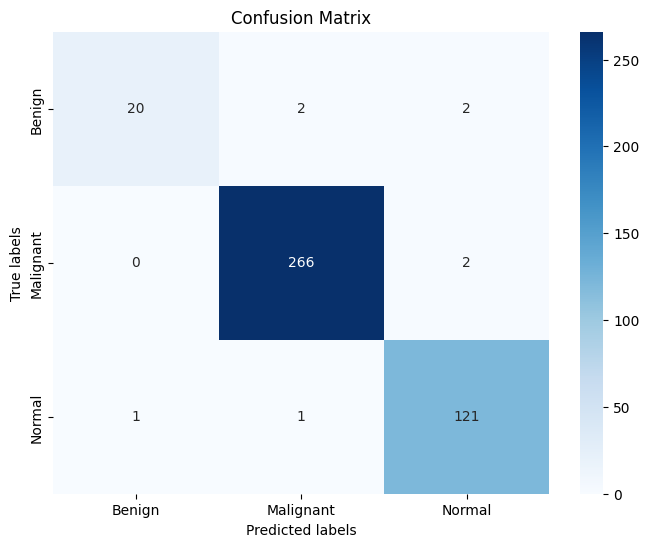

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(orig_test_labels, np.argmax(pred_y, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant', 'Normal'], yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


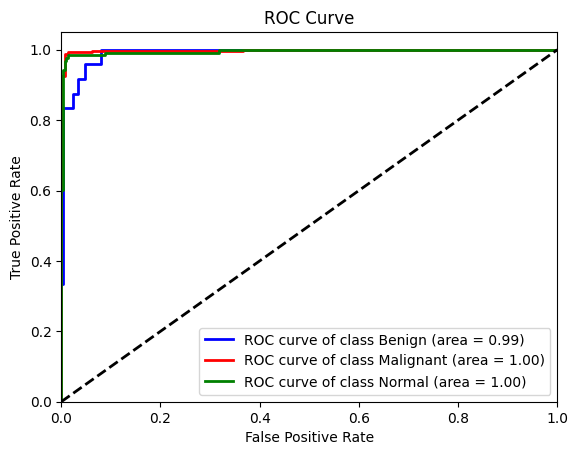

In [17]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], pred_y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = ['blue', 'red', 'green']
labels = ['Benign', 'Malignant', 'Normal']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
